In [1]:
import numpy as np
from matplotlib import pyplot as plt, cm as cm, patheffects as pe

%matplotlib inline

In [2]:
bpass_dir = '../data/BPASS/BPASSv2.1_imf135_300/'
logages = np.genfromtxt(bpass_dir+'numbers-bin.z014.dat',unpack=True,usecols=(0))

In [3]:
cols_dict = {'WR':(8,9,10,18,19,20),'RSG':(6,7),'WC':(10,20),'WN':(9,19),'BSG':(1,2,3,4,11,12,13,14),'YSG':(5),'O':(1,11),'B':(3,13)}

In [4]:
zs = ['zem5','zem4','z001','z002','z004','z006','z008','z010','z014','z020','z030','z040']
z_float = [1.0e-5,1.0e-4,0.001,0.002,0.004,0.006,0.008,0.01,0.014,0.020,0.030,0.040]
f_bins = np.linspace(0,1,11)
i_younger_than_100Myr = np.where(logages <= 8)
ts = logages[i_younger_than_100Myr]

In [5]:
def get_arrs(subtype,z):
    """
    Given a subtype of star, gets the appropriate summed arrays from the data tables for both
    single and binary populations
    
    Parameters
    ----------
    subtype : str
        Subtype of star. Currently supports WR, RSG, WC, WN, BSG, YSG, O
    z : str
        Metallicity, in format zXXX. Supports: zem5,zem4,z001,z002,z004,z006,z008,z010,
        z014,z020,z030,z040
    
    Returns
    -------
    b_sum : `~numpy.ndarray`
        Sum of all of the subsubtypes that go into the desired subtype for binaries
    s_sum : `~numpy.ndarray`
        Sum of all of the subsubtypes that go into the desired subtype for singles
    """
    
    b_filename = bpass_dir+'numbers-bin.{0}.dat'.format(z)
    s_filename = bpass_dir+'numbers.{0}.dat'.format(z)
    
    cols = cols_dict[subtype]
    
    b_arrs = np.genfromtxt(b_filename,usecols=cols_dict[subtype],dtype=np.float64)
    try:
        b_sum = np.sum(b_arrs,axis=1)
    except ValueError:
        b_sum = b_arrs
    
    s_arrs = np.genfromtxt(s_filename,usecols=cols_dict[subtype],dtype=np.float64)
    try:
        s_sum = np.sum(s_arrs,axis=1)
    except ValueError:
        s_sum = s_arrs
    
    return b_sum,s_sum

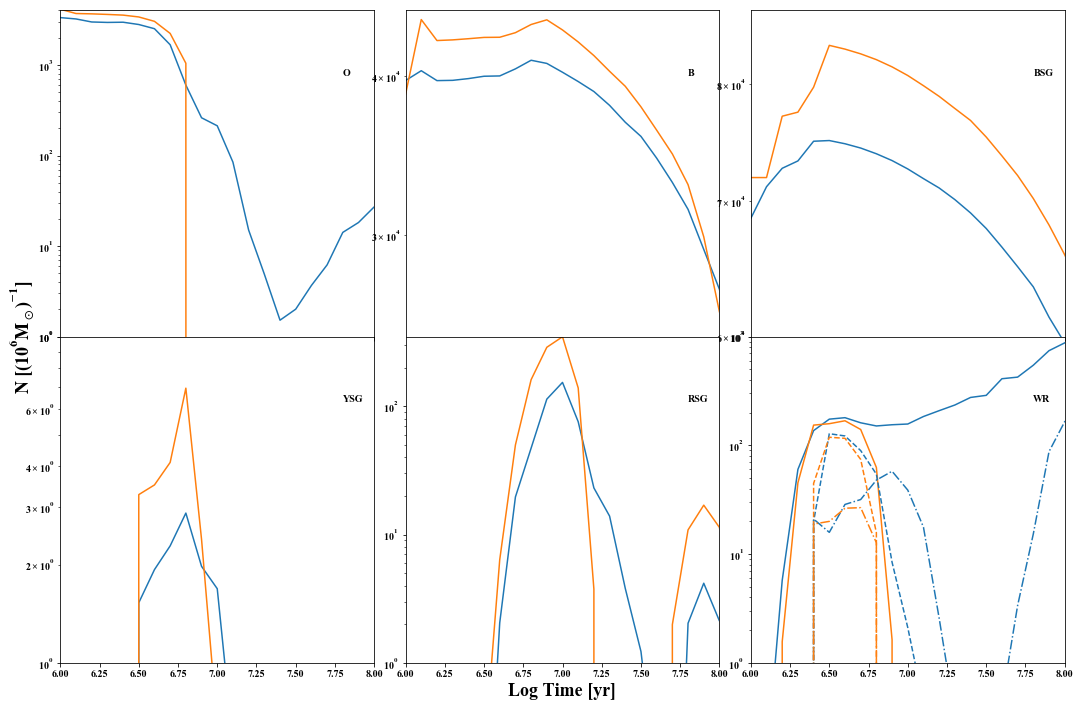

In [6]:
#Let's make a plot of all of the different types
fig = plt.figure(figsize=(18,12))
labax = fig.add_subplot(111)
ax1 = fig.add_subplot(231)
ax2 = fig.add_subplot(232,sharex=ax1)
ax3 = fig.add_subplot(233,sharex=ax1)
ax4 = fig.add_subplot(234,sharex=ax1)
ax5 = fig.add_subplot(235,sharex=ax1)
ax6 = fig.add_subplot(236,sharex=ax1)
labax.spines['top'].set_color('none')
labax.spines['bottom'].set_color('none')
labax.spines['left'].set_color('none')
labax.spines['right'].set_color('none')
labax.tick_params(labelcolor='w', top='off', bottom='off', left='off', right='off')
fig.subplots_adjust(wspace=0.1,hspace=0)
plt.setp([a.get_xticklabels() for a in [ax1,ax2,ax3]], visible=False)

ax1.plot(logages,get_arrs('O','z014')[0])
ax1.plot(logages,get_arrs('O','z014')[1])

ax2.plot(logages,get_arrs('B','z014')[0])
ax2.plot(logages,get_arrs('B','z014')[1])

ax3.plot(logages,get_arrs('BSG','z014')[0])
ax3.plot(logages,get_arrs('BSG','z014')[1])

ax4.plot(logages,get_arrs('YSG','z014')[0])
ax4.plot(logages,get_arrs('YSG','z014')[1])

ax5.plot(logages,get_arrs('RSG','z014')[0])
ax5.plot(logages,get_arrs('RSG','z014')[1])

ax6.plot(logages,get_arrs('WR','z014')[0],c='C0')
ax6.plot(logages,get_arrs('WR','z014')[1],c='C1')
ax6.plot(logages,get_arrs('WC','z014')[0],c='C0',ls='--')
ax6.plot(logages,get_arrs('WC','z014')[1],c='C1',ls='--')
ax6.plot(logages,get_arrs('WN','z014')[0],c='C0',ls='-.')
ax6.plot(logages,get_arrs('WN','z014')[1],c='C1',ls='-.')

ax1.set(xlim=(6,8), ylim=(1,4000),yscale='log')
ax2.set(ylim=(2.5e4,4.5e4),yscale='log')
ax3.set(ylim=(6e4,8.7e4),yscale='log')
ax4.set(ylim=(1,10),yscale='log')
ax5.set(ylim=(1,350),yscale='log')
ax6.set(ylim=(1,1000),yscale='log')

ax1.annotate('O', xy=(0,0), xycoords='axes fraction', xytext=(0.9, 0.8), textcoords='axes fraction')
ax2.annotate('B', xy=(0,0), xycoords='axes fraction', xytext=(0.9, 0.8), textcoords='axes fraction')
ax3.annotate('BSG', xy=(0,0), xycoords='axes fraction', xytext=(0.9, 0.8), textcoords='axes fraction')
ax4.annotate('YSG', xy=(0,0), xycoords='axes fraction', xytext=(0.9, 0.8), textcoords='axes fraction')
ax5.annotate('RSG', xy=(0,0), xycoords='axes fraction', xytext=(0.9, 0.8), textcoords='axes fraction')
ax6.annotate('WR', xy=(0,0), xycoords='axes fraction', xytext=(0.9, 0.8), textcoords='axes fraction')


labax.set_xlabel('Log Time [yr]',fontsize=18,family='serif')
labax.set_ylabel('N [$(10^6 M_\odot)^{-1}$]',fontsize=18,family='serif')

plt.savefig('../plots/z014_all_comp.eps')

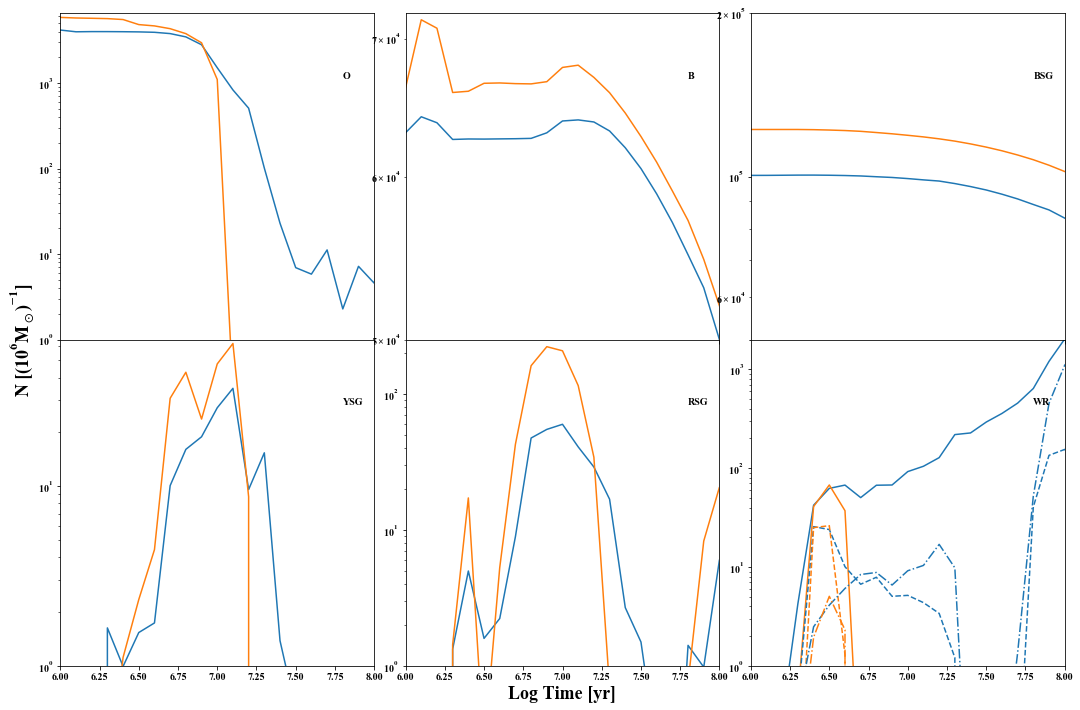

In [7]:
#Let's make a plot of all of the different ratios, now at SMC metallicity
fig = plt.figure(figsize=(18,12))
labax = fig.add_subplot(111)
ax1 = fig.add_subplot(231)
ax2 = fig.add_subplot(232,sharex=ax1)
ax3 = fig.add_subplot(233,sharex=ax1)
ax4 = fig.add_subplot(234,sharex=ax1)
ax5 = fig.add_subplot(235,sharex=ax1)
ax6 = fig.add_subplot(236,sharex=ax1)
labax.spines['top'].set_color('none')
labax.spines['bottom'].set_color('none')
labax.spines['left'].set_color('none')
labax.spines['right'].set_color('none')
labax.tick_params(labelcolor='w', top='off', bottom='off', left='off', right='off')
fig.subplots_adjust(wspace=0.1,hspace=0)
plt.setp([a.get_xticklabels() for a in [ax1,ax2,ax3]], visible=False)

ax1.plot(logages,get_arrs('O','z002')[0])
ax1.plot(logages,get_arrs('O','z002')[1])

ax2.plot(logages,get_arrs('B','z002')[0])
ax2.plot(logages,get_arrs('B','z002')[1])

ax3.plot(logages,get_arrs('BSG','z002')[0])
ax3.plot(logages,get_arrs('BSG','z002')[1])

ax4.plot(logages,get_arrs('YSG','z002')[0])
ax4.plot(logages,get_arrs('YSG','z002')[1])

ax5.plot(logages,get_arrs('RSG','z002')[0])
ax5.plot(logages,get_arrs('RSG','z002')[1])

ax6.plot(logages,get_arrs('WR','z002')[0],c='C0')
ax6.plot(logages,get_arrs('WR','z002')[1],c='C1')
ax6.plot(logages,get_arrs('WC','z002')[0],c='C0',ls='--')
ax6.plot(logages,get_arrs('WC','z002')[1],c='C1',ls='--')
ax6.plot(logages,get_arrs('WN','z002')[0],c='C0',ls='-.')
ax6.plot(logages,get_arrs('WN','z002')[1],c='C1',ls='-.')

ax1.set(xlim=(6,8), ylim=(1,6500),yscale='log')
ax2.set(ylim=(5e4,7.2e4),yscale='log')
ax3.set(ylim=(5e4,2e5),yscale='log')
ax4.set(ylim=(1,65),yscale='log')
ax5.set(ylim=(1,250),yscale='log')
ax6.set(ylim=(1,2000),yscale='log')

ax1.annotate('O', xy=(0,0), xycoords='axes fraction', xytext=(0.9, 0.8), textcoords='axes fraction')
ax2.annotate('B', xy=(0,0), xycoords='axes fraction', xytext=(0.9, 0.8), textcoords='axes fraction')
ax3.annotate('BSG', xy=(0,0), xycoords='axes fraction', xytext=(0.9, 0.8), textcoords='axes fraction')
ax4.annotate('YSG', xy=(0,0), xycoords='axes fraction', xytext=(0.9, 0.8), textcoords='axes fraction')
ax5.annotate('RSG', xy=(0,0), xycoords='axes fraction', xytext=(0.9, 0.8), textcoords='axes fraction')
ax6.annotate('WR', xy=(0,0), xycoords='axes fraction', xytext=(0.9, 0.8), textcoords='axes fraction')

labax.set_xlabel('Log Time [yr]',fontsize=18,family='serif')
labax.set_ylabel('N [$(10^6 M_\odot)^{-1}$]',fontsize=18,family='serif')

plt.savefig('../plots/z002_all_comp.eps')

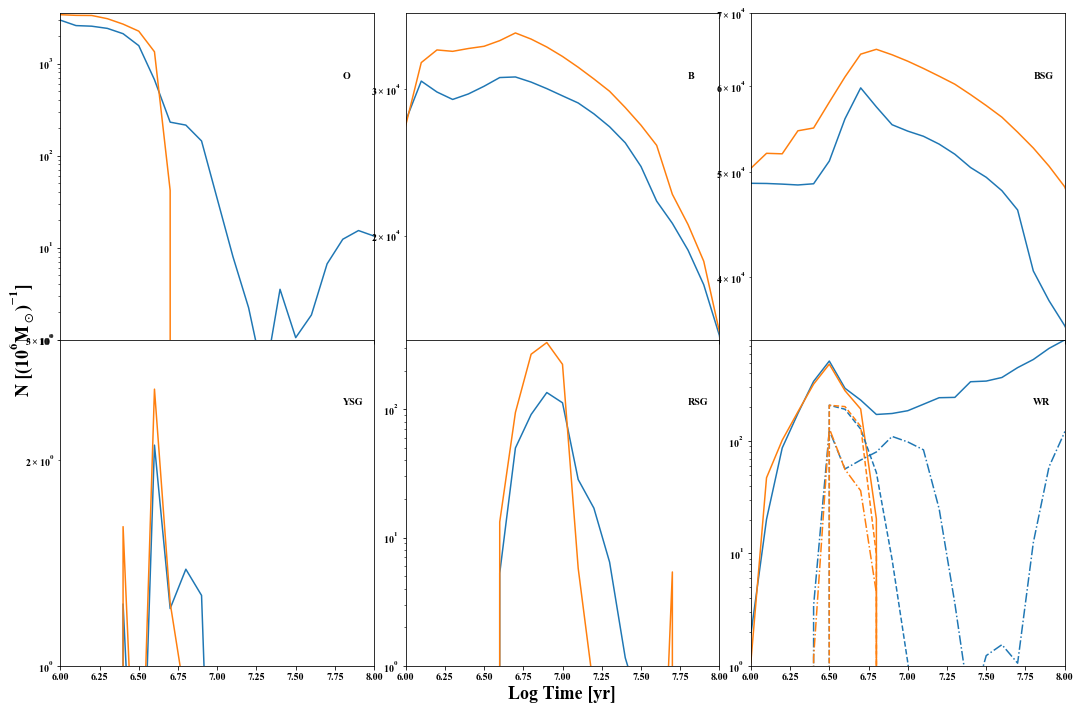

In [8]:
#Let's make a plot of all of the different ratios, now at 2x solar metallicity
fig = plt.figure(figsize=(18,12))
labax = fig.add_subplot(111)
ax1 = fig.add_subplot(231)
ax2 = fig.add_subplot(232,sharex=ax1)
ax3 = fig.add_subplot(233,sharex=ax1)
ax4 = fig.add_subplot(234,sharex=ax1)
ax5 = fig.add_subplot(235,sharex=ax1)
ax6 = fig.add_subplot(236,sharex=ax1)
labax.spines['top'].set_color('none')
labax.spines['bottom'].set_color('none')
labax.spines['left'].set_color('none')
labax.spines['right'].set_color('none')
labax.tick_params(labelcolor='w', top='off', bottom='off', left='off', right='off')
fig.subplots_adjust(wspace=0.1,hspace=0)
plt.setp([a.get_xticklabels() for a in [ax1,ax2,ax3]], visible=False)

ax1.plot(logages,get_arrs('O','z040')[0])
ax1.plot(logages,get_arrs('O','z040')[1])

ax2.plot(logages,get_arrs('B','z040')[0])
ax2.plot(logages,get_arrs('B','z040')[1])

ax3.plot(logages,get_arrs('BSG','z040')[0])
ax3.plot(logages,get_arrs('BSG','z040')[1])

ax4.plot(logages,get_arrs('YSG','z040')[0])
ax4.plot(logages,get_arrs('YSG','z040')[1])

ax5.plot(logages,get_arrs('RSG','z040')[0])
ax5.plot(logages,get_arrs('RSG','z040')[1])

ax6.plot(logages,get_arrs('WR','z040')[0],c='C0')
ax6.plot(logages,get_arrs('WR','z040')[1],c='C1')
ax6.plot(logages,get_arrs('WC','z040')[0],c='C0',ls='--')
ax6.plot(logages,get_arrs('WC','z040')[1],c='C1',ls='--')
ax6.plot(logages,get_arrs('WN','z040')[0],c='C0',ls='-.')
ax6.plot(logages,get_arrs('WN','z040')[1],c='C1',ls='-.')

ax1.set(xlim=(6,8), ylim=(1,3500),yscale='log')
ax2.set(ylim=(1.5e4,3.7e4),yscale='log')
ax3.set(ylim=(3.5e4,7e4),yscale='log')
ax4.set(ylim=(1,3),yscale='log')
ax5.set(ylim=(1,350),yscale='log')
ax6.set(ylim=(1,800),yscale='log')

ax1.annotate('O', xy=(0,0), xycoords='axes fraction', xytext=(0.9, 0.8), textcoords='axes fraction')
ax2.annotate('B', xy=(0,0), xycoords='axes fraction', xytext=(0.9, 0.8), textcoords='axes fraction')
ax3.annotate('BSG', xy=(0,0), xycoords='axes fraction', xytext=(0.9, 0.8), textcoords='axes fraction')
ax4.annotate('YSG', xy=(0,0), xycoords='axes fraction', xytext=(0.9, 0.8), textcoords='axes fraction')
ax5.annotate('RSG', xy=(0,0), xycoords='axes fraction', xytext=(0.9, 0.8), textcoords='axes fraction')
ax6.annotate('WR', xy=(0,0), xycoords='axes fraction', xytext=(0.9, 0.8), textcoords='axes fraction')

labax.set_xlabel('Log Time [yr]',fontsize=18,family='serif')
labax.set_ylabel('N [$(10^6 M_\odot)^{-1}$]',fontsize=18,family='serif')

plt.savefig('../plots/z040_all_comp.eps')

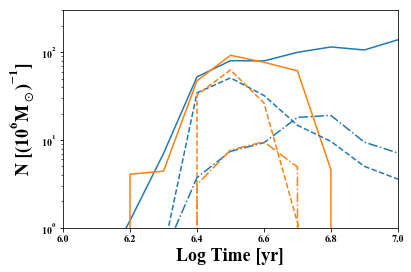

In [9]:
#Now WRs at II Zw 40 metallicity (z004)

plt.plot(logages,get_arrs('WR','z004')[0])
plt.plot(logages,get_arrs('WR','z004')[1])
plt.plot(logages,get_arrs('WC','z004')[0],c='C0',ls='--')
plt.plot(logages,get_arrs('WC','z004')[1],c='C1',ls='--')
plt.plot(logages,get_arrs('WN','z004')[0],c='C0',ls='-.')
plt.plot(logages,get_arrs('WN','z004')[1],c='C1',ls='-.')

plt.gca().set(ylim=(1,300),yscale='log',xlim=(6,7))

plt.gca().set_xlabel('Log Time [yr]',fontsize=18,family='serif')
plt.gca().set_ylabel('N [$(10^6 M_\odot)^{-1}$]',fontsize=18,family='serif')

plt.savefig('../plots/z004_wrs.eps')

In [10]:
def get_ratio_at_parameter(ratio,z,logtime,f_bin):
    """
    Given a ratio, gets the appropriate summed arrays from the data tables for both
    single and binary populations, interpolates to the binary fraction, and then the 
    time
    
    Parameters
    ----------
    ratio : str
        Name of ratio in the format 'X/Y'. You best hope 'X' and 'Y' are in cols_dict.
    z : str
        Metallicity, in format zXXX. Supports: zem5,zem4,z001,z002,z004,z006,z008,z010,
        z014,z020,z030,z040
    logtime : float
        Log of time in years. Will interpolate.
    f_bin : float
        Binary fraction, must be in range [0,1]
    
    Returns
    -------
    result : float
        The ratio at the given binary fraction, and metallicity, and time
    """
    
    subtypes = ratio.split('/')
    
    subtype1_b,subtype1_s = get_arrs(subtypes[0],z)
    subtype2_b,subtype2_s = get_arrs(subtypes[1],z)
    
    subtype1 = f_bin*subtype1_b + (1-f_bin)*subtype1_s
    subtype2 = f_bin*subtype2_b + (1-f_bin)*subtype2_s
    
    subtype1_t = np.interp(logtime,logages,subtype1,left=0,right=0)
    subtype2_t = np.interp(logtime,logages,subtype2,left=0,right=0)
    
    return np.divide(subtype1_t,subtype2_t)

In [12]:
bcmap = cm.get_cmap('plasma')
tcmap = cm.get_cmap('bone')
zcmap = cm.get_cmap('pink')

/Users/carina/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:36: RuntimeWarning: invalid value encountered in true_divide
/Users/carina/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:36: RuntimeWarning: divide by zero encountered in true_divide
/Users/carina/anaconda/lib/python3.5/site-packages/matplotlib/scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


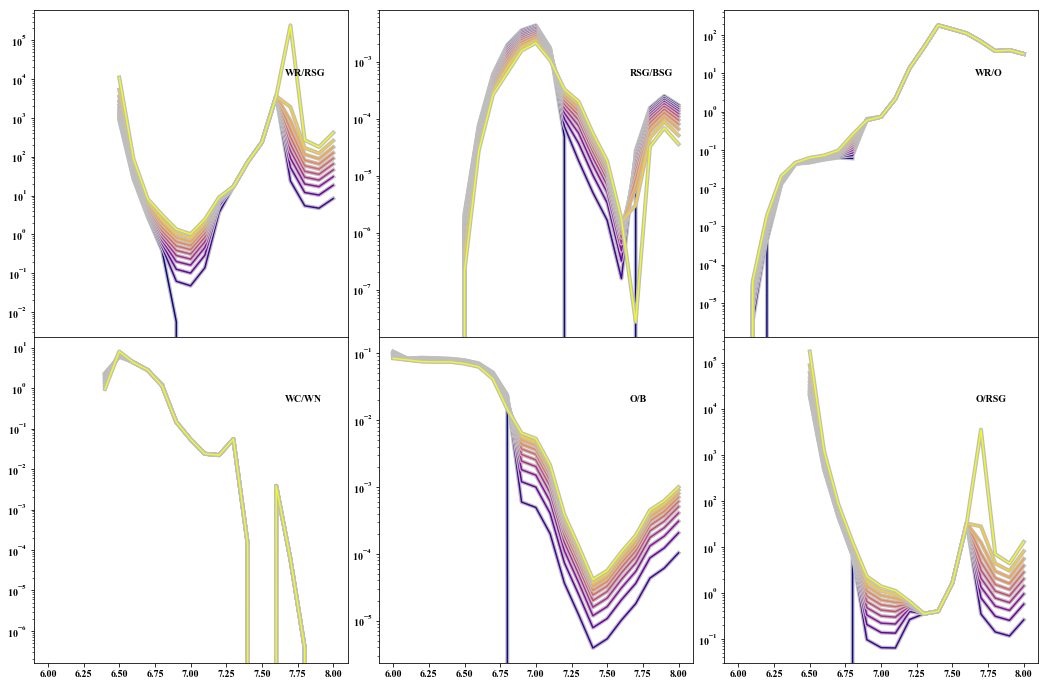

In [14]:
#Let's do the same thing for six ratios: WR/RSG, RSG/BSG, WR/O, WC/WN, O/B, WN/WR
fig = plt.figure(figsize=(18,12))
labax = fig.add_subplot(111)
ax1 = fig.add_subplot(231)
ax2 = fig.add_subplot(232,sharex=ax1)
ax3 = fig.add_subplot(233,sharex=ax1)
ax4 = fig.add_subplot(234,sharex=ax1)
ax5 = fig.add_subplot(235,sharex=ax1)
ax6 = fig.add_subplot(236,sharex=ax1)
labax.spines['top'].set_color('none')
labax.spines['bottom'].set_color('none')
labax.spines['left'].set_color('none')
labax.spines['right'].set_color('none')
labax.tick_params(labelcolor='w', top='off', bottom='off', left='off', right='off')
fig.subplots_adjust(wspace=0.1,hspace=0)
plt.setp([a.get_xticklabels() for a in [ax1,ax2,ax3]], visible=False)

for f_bin in f_bins:
    ax1.plot(ts,[get_ratio_at_parameter('WR/RSG','z014',t,f_bin) for t in ts],c=bcmap(f_bin),path_effects=[pe.Stroke(linewidth=4, foreground='0.75'), pe.Normal()])
    ax2.plot(ts,[get_ratio_at_parameter('RSG/BSG','z014',t,f_bin) for t in ts],c=bcmap(f_bin),path_effects=[pe.Stroke(linewidth=4, foreground='0.75'), pe.Normal()])
    ax3.plot(ts,[get_ratio_at_parameter('WR/O','z014',t,f_bin) for t in ts],c=bcmap(f_bin),path_effects=[pe.Stroke(linewidth=4, foreground='0.75'), pe.Normal()])
    ax4.plot(ts,[get_ratio_at_parameter('WC/WN','z014',t,f_bin) for t in ts],c=bcmap(f_bin),path_effects=[pe.Stroke(linewidth=4, foreground='0.75'), pe.Normal()])
    ax5.plot(ts,[get_ratio_at_parameter('O/B','z014',t,f_bin) for t in ts],c=bcmap(f_bin),path_effects=[pe.Stroke(linewidth=4, foreground='0.75'), pe.Normal()])
    ax6.plot(ts,[get_ratio_at_parameter('O/RSG','z014',t,f_bin) for t in ts],c=bcmap(f_bin),path_effects=[pe.Stroke(linewidth=4, foreground='0.75'), pe.Normal()])
    
for ax in [ax1,ax2,ax3,ax4,ax5,ax6]:
    ax.set(yscale='log')
    
ax1.annotate('WR/RSG', xy=(0,0), xycoords='axes fraction', xytext=(0.8, 0.8), textcoords='axes fraction')
ax2.annotate('RSG/BSG', xy=(0,0), xycoords='axes fraction', xytext=(0.8, 0.8), textcoords='axes fraction')
ax3.annotate('WR/O', xy=(0,0), xycoords='axes fraction', xytext=(0.8, 0.8), textcoords='axes fraction')
ax4.annotate('WC/WN', xy=(0,0), xycoords='axes fraction', xytext=(0.8, 0.8), textcoords='axes fraction')
ax5.annotate('O/B', xy=(0,0), xycoords='axes fraction', xytext=(0.8, 0.8), textcoords='axes fraction')
ax6.annotate('O/RSG', xy=(0,0), xycoords='axes fraction', xytext=(0.8, 0.8), textcoords='axes fraction')

plt.savefig('../plots/z014_ratios_comp.eps')

/Users/carina/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:36: RuntimeWarning: invalid value encountered in true_divide
/Users/carina/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:36: RuntimeWarning: divide by zero encountered in true_divide
/Users/carina/anaconda/lib/python3.5/site-packages/matplotlib/scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


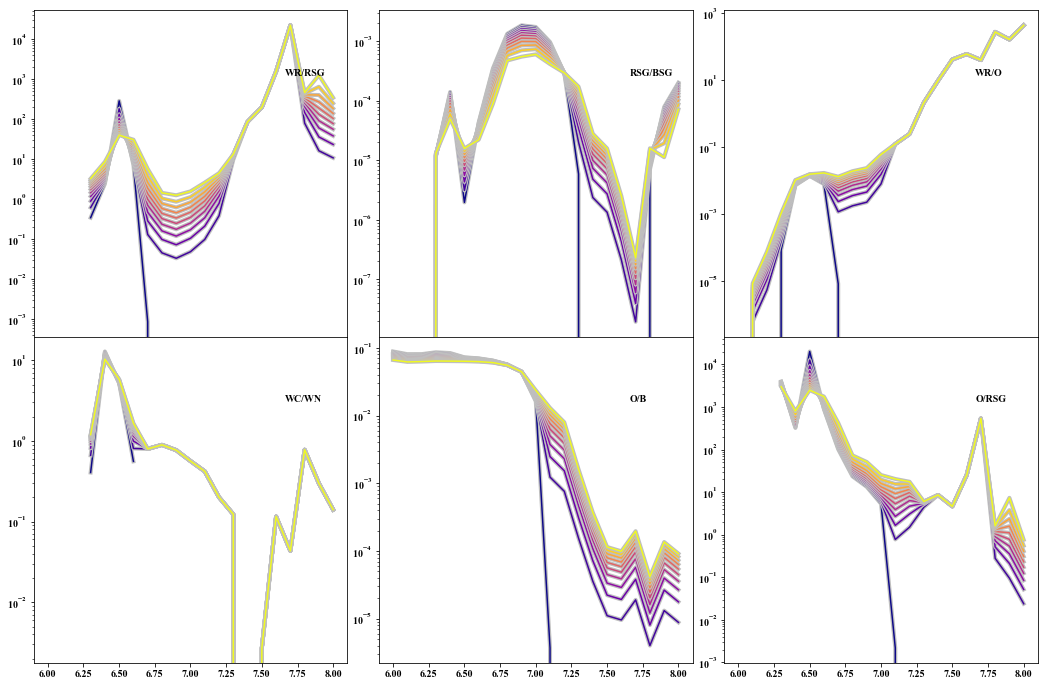

In [15]:
#Now SMC-metallicity
fig = plt.figure(figsize=(18,12))
labax = fig.add_subplot(111)
ax1 = fig.add_subplot(231)
ax2 = fig.add_subplot(232,sharex=ax1)
ax3 = fig.add_subplot(233,sharex=ax1)
ax4 = fig.add_subplot(234,sharex=ax1)
ax5 = fig.add_subplot(235,sharex=ax1)
ax6 = fig.add_subplot(236,sharex=ax1)
labax.spines['top'].set_color('none')
labax.spines['bottom'].set_color('none')
labax.spines['left'].set_color('none')
labax.spines['right'].set_color('none')
labax.tick_params(labelcolor='w', top='off', bottom='off', left='off', right='off')
fig.subplots_adjust(wspace=0.1,hspace=0)
plt.setp([a.get_xticklabels() for a in [ax1,ax2,ax3]], visible=False)

for f_bin in f_bins:
    ax1.plot(ts,[get_ratio_at_parameter('WR/RSG','z002',t,f_bin) for t in ts],c=bcmap(f_bin),path_effects=[pe.Stroke(linewidth=4, foreground='0.75'), pe.Normal()])
    ax2.plot(ts,[get_ratio_at_parameter('RSG/BSG','z002',t,f_bin) for t in ts],c=bcmap(f_bin),path_effects=[pe.Stroke(linewidth=4, foreground='0.75'), pe.Normal()])
    ax3.plot(ts,[get_ratio_at_parameter('WR/O','z002',t,f_bin) for t in ts],c=bcmap(f_bin),path_effects=[pe.Stroke(linewidth=4, foreground='0.75'), pe.Normal()])
    ax4.plot(ts,[get_ratio_at_parameter('WC/WN','z002',t,f_bin) for t in ts],c=bcmap(f_bin),path_effects=[pe.Stroke(linewidth=4, foreground='0.75'), pe.Normal()])
    ax5.plot(ts,[get_ratio_at_parameter('O/B','z002',t,f_bin) for t in ts],c=bcmap(f_bin),path_effects=[pe.Stroke(linewidth=4, foreground='0.75'), pe.Normal()])
    ax6.plot(ts,[get_ratio_at_parameter('O/RSG','z002',t,f_bin) for t in ts],c=bcmap(f_bin),path_effects=[pe.Stroke(linewidth=4, foreground='0.75'), pe.Normal()])
    
for ax in [ax1,ax2,ax3,ax4,ax5,ax6]:
    ax.set(yscale='log')
    
ax1.annotate('WR/RSG', xy=(0,0), xycoords='axes fraction', xytext=(0.8, 0.8), textcoords='axes fraction')
ax2.annotate('RSG/BSG', xy=(0,0), xycoords='axes fraction', xytext=(0.8, 0.8), textcoords='axes fraction')
ax3.annotate('WR/O', xy=(0,0), xycoords='axes fraction', xytext=(0.8, 0.8), textcoords='axes fraction')
ax4.annotate('WC/WN', xy=(0,0), xycoords='axes fraction', xytext=(0.8, 0.8), textcoords='axes fraction')
ax5.annotate('O/B', xy=(0,0), xycoords='axes fraction', xytext=(0.8, 0.8), textcoords='axes fraction')
ax6.annotate('O/RSG', xy=(0,0), xycoords='axes fraction', xytext=(0.8, 0.8), textcoords='axes fraction')

plt.savefig('../plots/z002_ratios_comp.eps')

/Users/carina/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:36: RuntimeWarning: divide by zero encountered in true_divide
/Users/carina/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:36: RuntimeWarning: invalid value encountered in true_divide
/Users/carina/anaconda/lib/python3.5/site-packages/matplotlib/scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


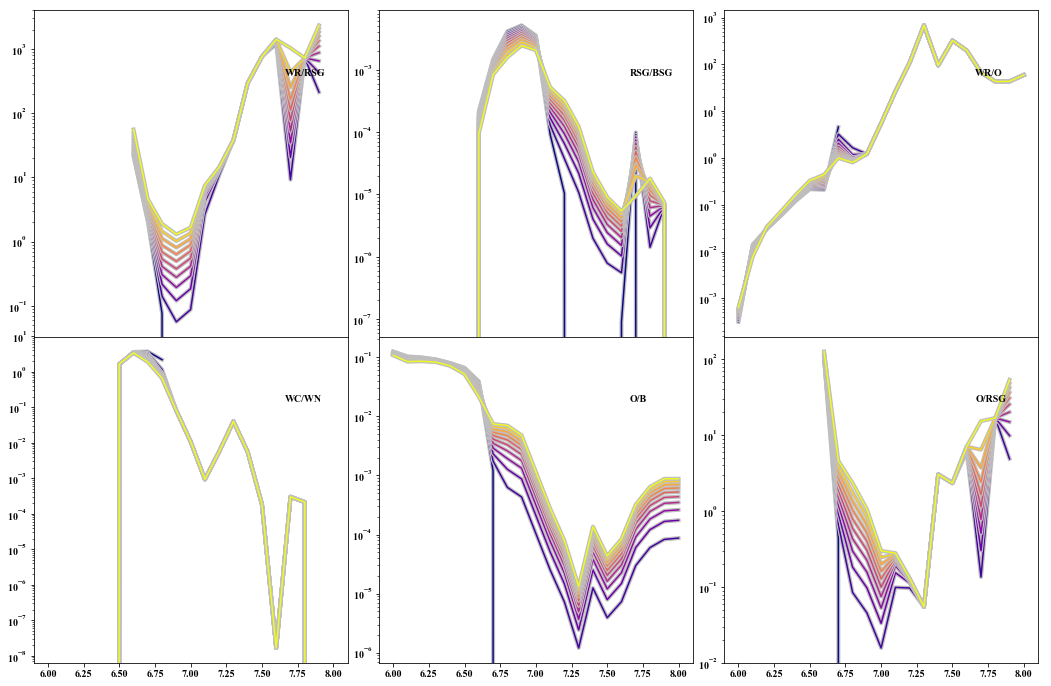

In [16]:
#Now ~2x Solar
fig = plt.figure(figsize=(18,12))
labax = fig.add_subplot(111)
ax1 = fig.add_subplot(231)
ax2 = fig.add_subplot(232,sharex=ax1)
ax3 = fig.add_subplot(233,sharex=ax1)
ax4 = fig.add_subplot(234,sharex=ax1)
ax5 = fig.add_subplot(235,sharex=ax1)
ax6 = fig.add_subplot(236,sharex=ax1)
labax.spines['top'].set_color('none')
labax.spines['bottom'].set_color('none')
labax.spines['left'].set_color('none')
labax.spines['right'].set_color('none')
labax.tick_params(labelcolor='w', top='off', bottom='off', left='off', right='off')
fig.subplots_adjust(wspace=0.1,hspace=0)
plt.setp([a.get_xticklabels() for a in [ax1,ax2,ax3]], visible=False)

for f_bin in f_bins:
    ax1.plot(ts,[get_ratio_at_parameter('WR/RSG','z040',t,f_bin) for t in ts],c=bcmap(f_bin),path_effects=[pe.Stroke(linewidth=4, foreground='0.75'), pe.Normal()])
    ax2.plot(ts,[get_ratio_at_parameter('RSG/BSG','z040',t,f_bin) for t in ts],c=bcmap(f_bin),path_effects=[pe.Stroke(linewidth=4, foreground='0.75'), pe.Normal()])
    ax3.plot(ts,[get_ratio_at_parameter('WR/O','z040',t,f_bin) for t in ts],c=bcmap(f_bin),path_effects=[pe.Stroke(linewidth=4, foreground='0.75'), pe.Normal()])
    ax4.plot(ts,[get_ratio_at_parameter('WC/WN','z040',t,f_bin) for t in ts],c=bcmap(f_bin),path_effects=[pe.Stroke(linewidth=4, foreground='0.75'), pe.Normal()])
    ax5.plot(ts,[get_ratio_at_parameter('O/B','z040',t,f_bin) for t in ts],c=bcmap(f_bin),path_effects=[pe.Stroke(linewidth=4, foreground='0.75'), pe.Normal()])
    ax6.plot(ts,[get_ratio_at_parameter('O/RSG','z040',t,f_bin) for t in ts],c=bcmap(f_bin),path_effects=[pe.Stroke(linewidth=4, foreground='0.75'), pe.Normal()])
    
for ax in [ax1,ax2,ax3,ax4,ax5,ax6]:
    ax.set(yscale='log')
    
ax1.annotate('WR/RSG', xy=(0,0), xycoords='axes fraction', xytext=(0.8, 0.8), textcoords='axes fraction')
ax2.annotate('RSG/BSG', xy=(0,0), xycoords='axes fraction', xytext=(0.8, 0.8), textcoords='axes fraction')
ax3.annotate('WR/O', xy=(0,0), xycoords='axes fraction', xytext=(0.8, 0.8), textcoords='axes fraction')
ax4.annotate('WC/WN', xy=(0,0), xycoords='axes fraction', xytext=(0.8, 0.8), textcoords='axes fraction')
ax5.annotate('O/B', xy=(0,0), xycoords='axes fraction', xytext=(0.8, 0.8), textcoords='axes fraction')
ax6.annotate('O/RSG', xy=(0,0), xycoords='axes fraction', xytext=(0.8, 0.8), textcoords='axes fraction')

plt.savefig('../plots/z040_ratios_comp.eps')

In [17]:
parname_dict = {'f_bin':f_bins,'z':zs,'logtime':ts}
cmap_dict = {'f_bin':bcmap,'z':zcmap,'logtime':tcmap}
scale_dict = {'WC/WN':'linear','WR/RSG':'log','BSG/RSG':'log','WR/O':'log','WR/YSG':'log'}

In [18]:
def z_to_col(z):
    pos_in_arr = np.where(np.array(zs) == z)[0]/len(zs)
    return pos_in_arr[0]

def z_to_val(z):
    pos_in_arr = np.where(np.array(zs) == z)[0][0]
    z_f = z_float[pos_in_arr]
    return z_f

def t_to_col(t):
    pos_in_arr = np.where(np.array(ts) == t)[0]/len(ts)
    return pos_in_arr[0]

In [33]:
def plot_ratios(ratio1,ratio2,par3,par3val,constraint_dict=None):
    """
    Plots ratio1 vs. ratio2, at constant par3 for varying [the other parameters]
    
    constraint_dict gives constraints on e.g., z, f_bin, logtime
    ex: constraint_dict = {'logtime':(6,8),'f_bin':(0,1),'z':('zem5','z040')} gives default behavior
    """
    
    if constraint_dict is not None:
        
        if 'logtime' in constraint_dict:
            logtime_min,logtime_max = constraint_dict['logtime']
            ts_good = ts[(ts >= logtime_min) & (ts <= logtime_max)]
            
        else:
            ts_good = ts
            
        if 'f_bin' in constraint_dict:
            fbin_min,fbin_max = constraint_dict['f_bin']
            fbins_good = f_bins[(f_bins >= fbin_min) & (f_bins <= fbin_max)]
            
        else:
            fbins_good = f_bins
            
        if 'z' in constraint_dict:
            z_min,z_max = constraint_dict['z']
            zs_val = [z_to_val(z_t) for z_t in zs]
            zs_good = zs[(zs_val >= z_to_val(z_min)) & (zs_val <= z_to_val(z_max))]
            
        else:
            zs_good = zs
            
    else:
        
        ts_good = ts
        fbins_good = f_bins
        zs_good = zs
    
    
    fig,ax = plt.subplots(1,2,figsize=(12,6))
    
    if par3 == 'logtime':
        for f in fbins_good:
            r1 = [get_ratio_at_parameter(ratio1,f_bin=f,logtime=par3val,z=z_t) for z_t in zs_good]
            r2 = [get_ratio_at_parameter(ratio2,f_bin=f,logtime=par3val,z=z_t) for z_t in zs_good]
            ax[0].loglog(r1,r2,c=bcmap(f),lw=3,path_effects=[pe.Stroke(linewidth=4, foreground='0.75'), pe.Normal()])
            ax[1].axvline(x=f,c=bcmap(f),lw=3,path_effects=[pe.Stroke(linewidth=4, foreground='0.75'), pe.Normal()])
        for z_t in zs_good:
            r1 = [get_ratio_at_parameter(ratio1,f_bin=f,logtime=par3val,z=z_t) for f in fbins_good]
            r2 = [get_ratio_at_parameter(ratio2,f_bin=f,logtime=par3val,z=z_t) for f in fbins_good]
            ax[0].loglog(r1,r2,c=zcmap(z_to_col(z_t)),lw=3,path_effects=[pe.Stroke(linewidth=4, foreground='0.75'), pe.Normal()])
            ax[1].axhline(y=np.log10(z_to_val(z_t)),c=zcmap(z_to_col(z_t)),lw=3,path_effects=[pe.Stroke(linewidth=4, foreground='0.75'), pe.Normal()])
        ax[1].set(xlabel=r'$f_{bin}$',ylabel=r'$\log{Z}$') 
        
    elif par3 == 'f_bin':
        for t in ts_good:
            r1 = [get_ratio_at_parameter(ratio1,f_bin=par3val,logtime=t,z=z_t) for z_t in zs_good]
            r2 = [get_ratio_at_parameter(ratio2,f_bin=par3val,logtime=t,z=z_t) for z_t in zs_good]
            ax[0].loglog(r1,r2,c=tcmap(t_to_col(t)),lw=3,path_effects=[pe.Stroke(linewidth=4, foreground='0.75'), pe.Normal()])
            ax[1].axvline(t,c=tcmap(t_to_col(t)),lw=3,path_effects=[pe.Stroke(linewidth=4, foreground='0.75'), pe.Normal()])
        for z_t in zs_good:
            r1 = [get_ratio_at_parameter(ratio1,f_bin=par3val,logtime=t,z=z_t) for t in ts_good]
            r2 = [get_ratio_at_parameter(ratio2,f_bin=par3val,logtime=t,z=z_t) for t in ts_good]
            ax[0].loglog(r1,r2,c=zcmap(z_to_col(z_t)),lw=3,path_effects=[pe.Stroke(linewidth=4, foreground='0.75'), pe.Normal()])
            ax[1].axhline(y=np.log10(z_to_val(z_t)),c=zcmap(z_to_col(z_t)),lw=3,path_effects=[pe.Stroke(linewidth=4, foreground='0.75'), pe.Normal()])  
        ax[1].set(xlabel=r'$\log{t}$',ylabel=r'$\log{Z}$') 
        
    elif par3 == 'z':
        for f in fbins_good:
            r1 = [get_ratio_at_parameter(ratio1,f_bin=f,logtime=t,z=par3val) for t in ts_good]
            r2 = [get_ratio_at_parameter(ratio2,f_bin=f,logtime=t,z=par3val) for t in ts_good]
            ax[0].loglog(r1,r2,c=bcmap(f),lw=3,path_effects=[pe.Stroke(linewidth=4, foreground='0.75'), pe.Normal()])
            ax[1].axhline(y=f,c=bcmap(f),lw=3,path_effects=[pe.Stroke(linewidth=4, foreground='0.75'), pe.Normal()])
        for t in ts_good:
            r1 = [get_ratio_at_parameter(ratio1,f_bin=f,logtime=t,z=par3val) for f in fbins_good]
            r2 = [get_ratio_at_parameter(ratio2,f_bin=f,logtime=t,z=par3val) for f in fbins_good]
            ax[0].loglog(r1,r2,c=tcmap(t_to_col(t)),lw=3,path_effects=[pe.Stroke(linewidth=4, foreground='0.75'), pe.Normal()])
            ax[1].axvline(t,c=tcmap(t_to_col(t)),lw=3,path_effects=[pe.Stroke(linewidth=4, foreground='0.75'), pe.Normal()])
        ax[1].set(xlabel=r'$\log{t}$',ylabel=r'$f_{bin}$') 
        
    ax[0].set(xlabel=r'${}$'.format(ratio1),ylabel=r'${}$'.format(ratio2),title=par3+' = {0}'.format(par3val))
    
    return fig,ax

In [20]:
def calc_ratio_err(spec1,spec2):
    """
    Calculates the observed ratio and error spec1/spec2, sigma_spec1/spec2
    """
    
    result = spec1/spec2
    
    err = result*np.sqrt((1.0/spec1) + (1.0/spec2))
    
    return result,err

In [21]:
#Clusters

#Westerlund 1, 4.5 Myr, Solar, Crowther+06 MNRAS, Clark+05 A&A
WC_W = 8.0
WN_W = 16.0
WR_W = WC_W + WN_W
O_W = 22.0
RSG_W = 3.0
BSG_W = 29.0

#SGR 1806-20, 4 Myr, Solar, Figer+03 ApJ
WC_S = 2.0
WN_S = 2.0
WR_S = WC_S + WN_S
O_S = 5.0
RSG_S = 0.0
BSG_S = 5.0

#NGC 3603, 1.5 Myr, solar, Melena+08 AJ
WC_N = 0.0
WN_N = 3.0
WR_N = WC_N + WN_N
O_N = 34.0
RSG_N = 0.0
BSG_N = 3.0

#R136, 1.5 Myr, LMC, Doran+13 A&A
WC_R = 1.0
WN_R = 11.0
WR_R = WC_R + WN_R
O_R = 60.0
RSG_R = 0.0
BSG_R = 15.0

#Quintuplet, 4 Myr, > solar, Figer+99 ApJ
WC_Q = 9.0
WN_Q = 6.0
WR_Q = WC_Q + WN_Q
O_Q = 3.0
RSG_Q = 1.0
BSG_Q = 15.0

#Cygnus OB2, 1-7 Myr, ~solar?, Wright+15 MNRAS
WC_C = 2.0
WN_C = 1.0
WR_C = WC_C + WN_C
O_C = 52.0
RSG_C = 0.0
BSG_C = 22.0

#NGC 6231, 2-7 Myr, ~solar?, Kuhn+17 AJ
WC_N2 = 1.0
WN_N2 = 0.0
WR_N2 = WC_N2 + WN_N2
O_N2 = 13.0
RSG_N2 = 0.0
BSG_N2 = 3.0

/Users/carina/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:36: RuntimeWarning: invalid value encountered in true_divide
/Users/carina/anaconda/lib/python3.5/site-packages/matplotlib/scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


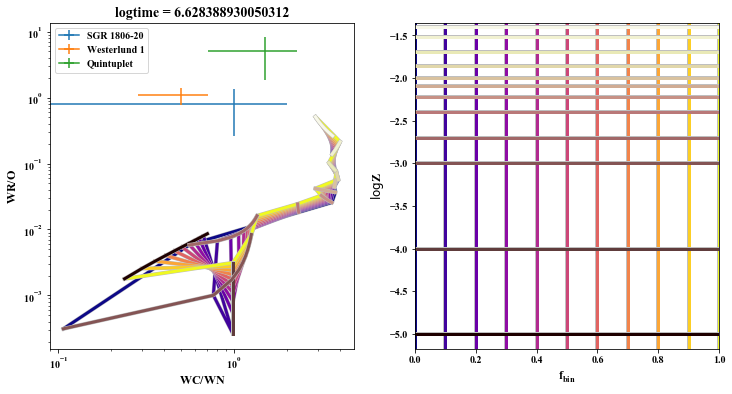

In [22]:
#Let's figure out a good ratio for 4.25 Myr
fig, ax = plot_ratios(ratio1='WC/WN',ratio2='WR/O',par3='logtime',par3val=np.log10(4.25e6))

CN_S,CN_S_err = calc_ratio_err(WC_S,WN_S)
CN_W,CN_W_err = calc_ratio_err(WC_W,WN_W)
CN_Q,CN_Q_err = calc_ratio_err(WC_Q,WN_Q)

WO_S,WO_S_err = calc_ratio_err(WR_S,O_S)
WO_W,WO_W_err = calc_ratio_err(WR_W,O_W)
WO_Q,WO_Q_err = calc_ratio_err(WR_Q,O_Q)

ax[0].errorbar(CN_S,WO_S,xerr=CN_S_err,yerr=WO_S_err,label='SGR 1806-20')
ax[0].errorbar(CN_W,WO_W,xerr=CN_W_err,yerr=WO_W_err,label='Westerlund 1')
ax[0].errorbar(CN_Q,WO_Q,xerr=CN_Q_err,yerr=WO_Q_err,label='Quintuplet')

ax[0].legend();

/Users/carina/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:36: RuntimeWarning: divide by zero encountered in true_divide
/Users/carina/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:36: RuntimeWarning: invalid value encountered in true_divide
/Users/carina/anaconda/lib/python3.5/site-packages/matplotlib/scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


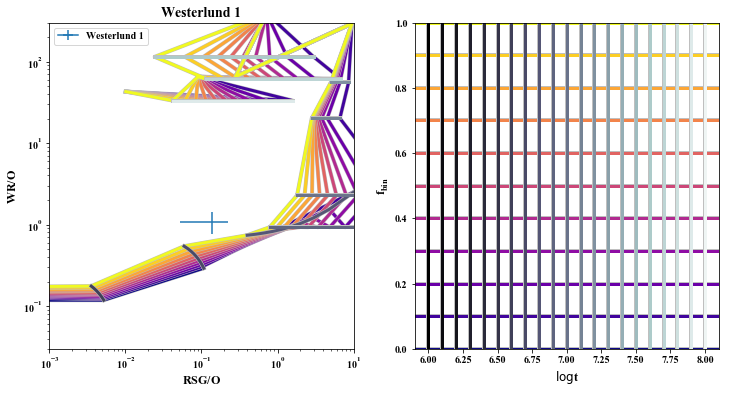

In [23]:
#Let's try it for individual clusters
#Westerlund 1!
fig, ax = plot_ratios(ratio1='RSG/O',ratio2='WR/O',par3='z',par3val='z030')

RO_W,RO_W_err = calc_ratio_err(RSG_W,O_W)
WO_W,WO_W_err = calc_ratio_err(WR_W,O_W)

ax[0].errorbar(RO_W,WO_W,xerr=RO_W_err,yerr=WO_W_err,label='Westerlund 1')
ax[0].set(ylim=(3e-2,3e2),xlim=(1e-3,1e1),title='Westerlund 1')
ax[0].legend();

/Users/carina/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:36: RuntimeWarning: divide by zero encountered in true_divide
/Users/carina/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:36: RuntimeWarning: invalid value encountered in true_divide
/Users/carina/anaconda/lib/python3.5/site-packages/matplotlib/scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


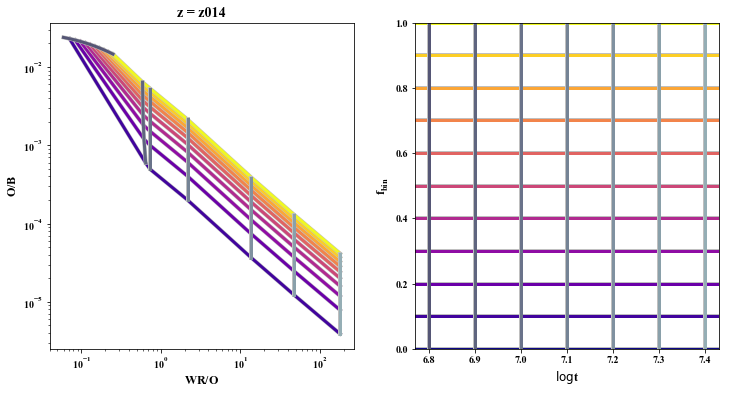

In [37]:
#Let's try it for a 25 Myr cluster
fig, ax = plot_ratios(ratio1='WR/O',ratio2='O/B',par3='z',par3val='z014',constraint_dict={'logtime':(6.75,7.4)})
#ax[0].set(ylim=(3e-2,1e-2),xlim=(1e-3,1e1))
plt.savefig('../plots/25_Myr_diagnostic.eps')